# Install

In [1]:
#%%capture prevents the output from being shown
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models.git
!pip install -U moabb

# Libraries

In [20]:
#Python libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

#Tensorflow and Sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical

#Import Databases
from EEG_Tensorflow_models.Utils.LoadData import load_dataset

#Import Model
from EEG_Tensorflow_models.Models.EEGNet import EEGNet

In [21]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Load the Database

In [3]:
# Gigascience dataset is loaded with the name Cho2017.
# For a complete list visit http://moabb.neurotechx.com/docs/dataset_summary.html
X_train, y_train, X_valid, y_valid, sfreq, info = load_dataset(dataset_name = 'Cho2017', subject_id=14, split=False) #If split is False, X_train == X_valid

num_chans = info['nchan']
chans_names = info['ch_names']

print(X_train.shape, y_train.shape)

MNE_DATA is not already configured. It will be set to default location in the home directory - /root/mne_data
All datasets will be downloaded to this location, if anything is already downloaded, please move manually to this location
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


/usr/local/lib/python3.10/dist-packages/moabb/datasets/download.py:55: RuntimeWarning: Setting non-standard config type: "MNE_DATASETS_GIGADB_PATH"
  set_config(key, get_config("MNE_DATA"))
100%|███████████████████████████████████████| 204M/204M [00:04<00:00, 41.2MB/s]
SHA256 hash of downloaded file: d80df4caafa163a62ef9c9533ef5baded9fb6a8aa7ae7ab6ecdb70bf45f05c83
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function scale is deprecated; will be removed in 0.8.0. Use numpy.multiply inside a lambda function instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 845 samples (1.650 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Used Annotations descriptions: ['left_hand', 'right_hand']
(200, 64, 1792, 1) (200,)


#Preprocess

In [4]:
# Transform our labels from sparse to onehot
num_classes = np.unique(y_train).shape[0]

y_train_onehot = to_categorical(y_train, num_classes = num_classes)
y_valid_onehot = to_categorical(y_valid, num_classes = num_classes)
print(y_train_onehot.shape, y_valid_onehot.shape)

(200, 2) (200, 2)


In [5]:
# GigaScience dataset tells us the MI window lies between 2.5s and 5s, so we only train with this window
frequency = 128
X_train_windowed = X_train[...,int(2.5*frequency):int(5*frequency),:]
X_valid_windowed = X_valid[...,int(2.5*frequency):int(5*frequency),:]
print(X_train_windowed.shape, X_valid_windowed.shape)

(200, 64, 320, 1) (200, 64, 320, 1)


In [6]:
# Shuffle and split de dataset
seed = 42

#Create the shuffler object
SSS = StratifiedShuffleSplit(n_splits = 1, train_size=0.8, test_size=0.2, random_state = seed)
partitions = list(SSS.split(X_train_windowed, y_train_onehot))

#Create the partition
x = X_train[partitions[0][0]]
y = y_train_onehot[partitions[0][0]]
x_test = X_train[partitions[0][1]]
y_test = y_train_onehot[partitions[0][1]]

#Training

In [12]:
model = EEGNet(nb_classes = num_classes, Chans=num_chans, Samples = X_train.shape[2])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = 'categorical_accuracy')

In [13]:
history = model.fit(x,y,
                    batch_size = 32,
                    epochs = 100,
                    validation_data = [x_test,y_test]
                    )

Epoch 1/100
5/5 [==============================] - 3s 218ms/step - loss: 0.6970 - categorical_accuracy: 0.5813 - val_loss: 0.6927 - val_categorical_accuracy: 0.5750
Epoch 2/100
5/5 [==============================] - 0s 63ms/step - loss: 0.6766 - categorical_accuracy: 0.6250 - val_loss: 0.6922 - val_categorical_accuracy: 0.6250
Epoch 3/100
5/5 [==============================] - 0s 56ms/step - loss: 0.6604 - categorical_accuracy: 0.6812 - val_loss: 0.6915 - val_categorical_accuracy: 0.5750
Epoch 4/100
5/5 [==============================] - 0s 56ms/step - loss: 0.6481 - categorical_accuracy: 0.6562 - val_loss: 0.6904 - val_categorical_accuracy: 0.6000
Epoch 5/100
5/5 [==============================] - 0s 56ms/step - loss: 0.6348 - categorical_accuracy: 0.7250 - val_loss: 0.6892 - val_categorical_accuracy: 0.6250
Epoch 6/100
5/5 [==============================] - 0s 56ms/step - loss: 0.6161 - categorical_accuracy: 0.7500 - val_loss: 0.6878 - val_categorical_accuracy: 0.6250
Epoch 7/100
5/5

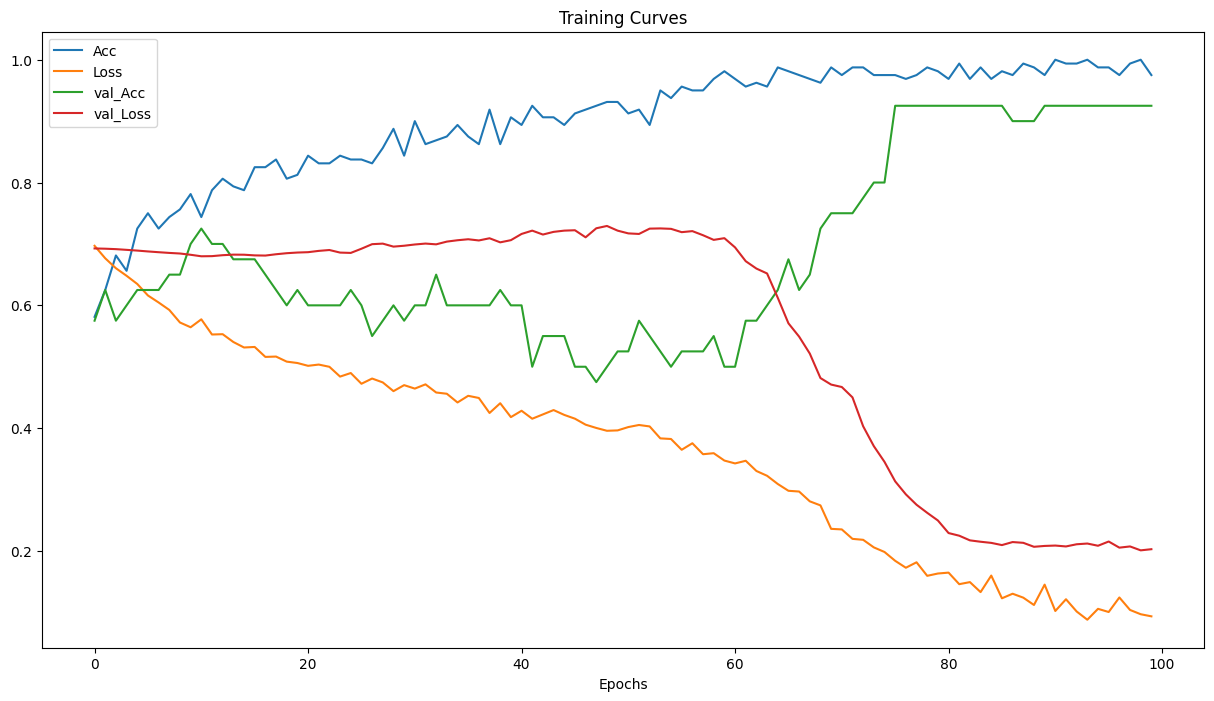

In [24]:
fig = plt.figure(figsize=(15,8))
plt.plot(history.history['categorical_accuracy'], label = 'Acc')
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_categorical_accuracy'], label='val_Acc')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.xlabel('Epochs')
plt.title('Training Curves')
plt.legend()
plt.show()